Mounted at /content/drive
Using device: cpu
Initial number of records: 1265657
Value counts before filtering:
trace_category
earthquake_local    1030231
noise                235426
Name: count, dtype: int64


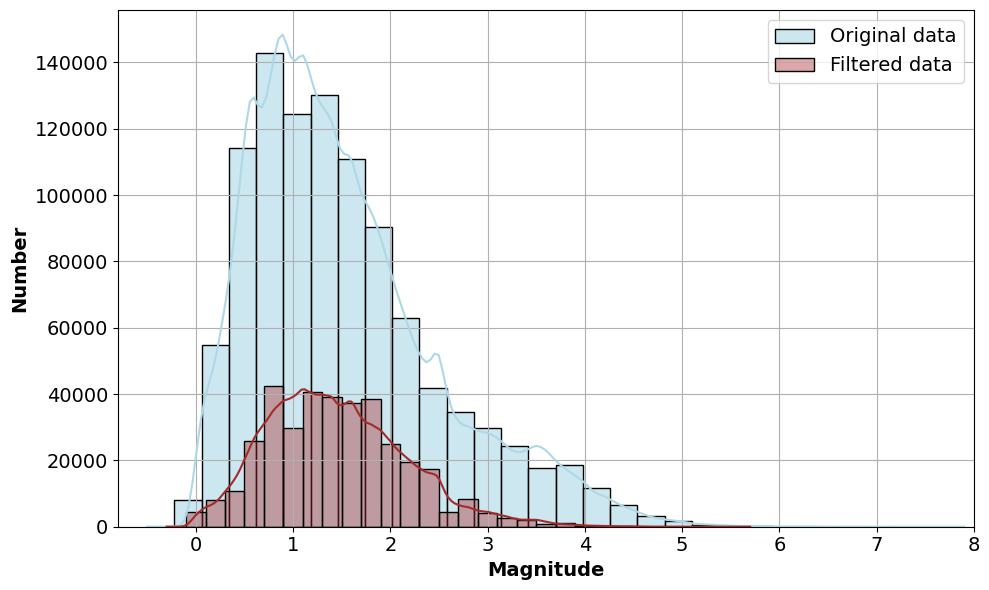

In [1]:
# -*- coding: utf-8 -*-
"""MagNet_chronological_split_EDA_v4_COPY.ipynb"""

from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision torchaudio
!pip install h5py pandas tqdm matplotlib torchinfo seaborn
# !pip install obspy

import time
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time

# import obspy
# from obspy import UTCDateTime
# from obspy.clients.fdsn import Client

# start time
start_time = time.time()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Disable cuDNN benchmarking to avoid cuDNN warnings
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = True

# Data loading and conversion functions
class EarthquakeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def load_data(file_name, file_list):
    X = []
    Y = []
    dtfl = h5py.File(file_name, 'r')
    for evi in tqdm(file_list):
        dataset = dtfl.get(f'data/{evi}')
        if dataset is None:
            print(f"Dataset not found for event ID: {evi}")
            continue
        data = np.array(dataset)
        spt = int(dataset.attrs['p_arrival_sample'])
        dshort = data[spt-100:spt+2900, :]
        X.append(dshort)
        mag = round(float(dataset.attrs['source_magnitude']), 2)
        Y.append(mag)
    dtfl.close()
    X = np.array(X)  # Convert list to numpy array
    Y = np.array(Y)  # Convert list to numpy array
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

def string_convertor(dd):
    dd2 = dd.split()
    SNR = []
    for d in dd2:
        if d not in ['[', ']']:
            dL = d.split('[')
            dR = d.split(']')
            if len(dL) == 2:
                dig = dL[1]
            elif len(dR) == 2:
                dig = dR[0]
            elif len(dR) == 1 and len(dL) == 1:
                dig = d
            try:
                dig = float(dig)
            except Exception:
                dig = None
            SNR.append(dig)
    return SNR

# Define the paths to your data files
file_name = "/content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Datasets/STEAD/merge.hdf5"
csv_file = "/content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Datasets/STEAD/merge.csv"

# Verify file existence
assert os.path.isfile(file_name), f"HDF5 file not found at {file_name}"
assert os.path.isfile(csv_file), f"CSV file not found at {csv_file}"

# Load and filter the dataset
df = pd.read_csv(csv_file, low_memory=False)
print(f"Initial number of records: {len(df)}")

# Display the value counts for the 'trace_category' column before filtering
print("Value counts before filtering:")
trace_category_counts_before = df["trace_category"].value_counts()
print(trace_category_counts_before)

max_magnitude = df["source_magnitude"].max()
min_magnitude = df["source_magnitude"].min()

# Store original dataframe before preprocessing
initial_df = df.copy()

# Ensure the 'source_origin_time' column is in datetime format
df['source_origin_time'] = pd.to_datetime(df['source_origin_time'])

# Sort by source_origin_time to ensure chronological order
df = df.sort_values(by='source_origin_time')

# Simplified filtering for debugging
df = df[df.trace_category == 'earthquake_local']
df = df[df.source_distance_km <= 110]
df = df[df.source_magnitude_type == 'ml']
df = df[df.p_arrival_sample >= 200]
df = df[df.p_arrival_sample + 2900 <= 6000]
df = df[df.p_arrival_sample <= 1500]
df = df[df.s_arrival_sample >= 200]
df = df[df.s_arrival_sample <= 2500]

# Fix coda_end_sample column parsing
df['coda_end_sample'] = df['coda_end_sample'].apply(lambda x: float(x.strip('[]')))
df = df.dropna(subset=['coda_end_sample'])
df = df[df['coda_end_sample'] <= 3000]

df = df[df.p_travel_sec.notnull()]
df = df[df.p_travel_sec > 0]
df = df[df.source_distance_km.notnull()]
df = df[df.source_distance_km > 0]
df = df[df.source_depth_km.notnull()]
df = df[df.source_magnitude.notnull()]
df = df[df.back_azimuth_deg.notnull()]
df = df[df.back_azimuth_deg > 0]
df.snr_db = df.snr_db.apply(lambda x: np.mean(string_convertor(x)))
df = df[df.snr_db >= 20]



# Create overlaid histogram plot
plt.figure(figsize=(10, 6))

# Plot original data histogram
sns.histplot(data=initial_df["source_magnitude"],
            bins=30,
            kde=True,
            color='lightblue',
            alpha=0.6,
            label='Original data')

# Plot preprocessed data histogram
sns.histplot(data=df["source_magnitude"],
            bins=30,
            kde=True,
            color='brown',
            alpha=0.4,
            label='Filtered data')

# Customize plot
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.legend(fontsize=14)
# plt.xlim(min_magnitude, max_magnitude)
plt.xlim(-0.8, 8)

# # Add title with magnitude information
# plt.title('Magnitude distribution of events in STEAD dataset before\n'
#           f'(min M = {initial_df["source_magnitude"].min():.1f}, max M = {initial_df["source_magnitude"].max():.1f}) and\n'
#           f'after (min M = {df["source_magnitude"].min():.1f}, max M = {df["source_magnitude"].max():.1f}) preprocessing',
#           fontsize=12,
#           pad=20)

plt.tight_layout()
plt.show()

In [2]:
print(len(df))

362354


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Initial number of records: 1265657
Value counts before filtering:
trace_category
earthquake_local    1030231
noise                235426
Name: count, dtype: int64


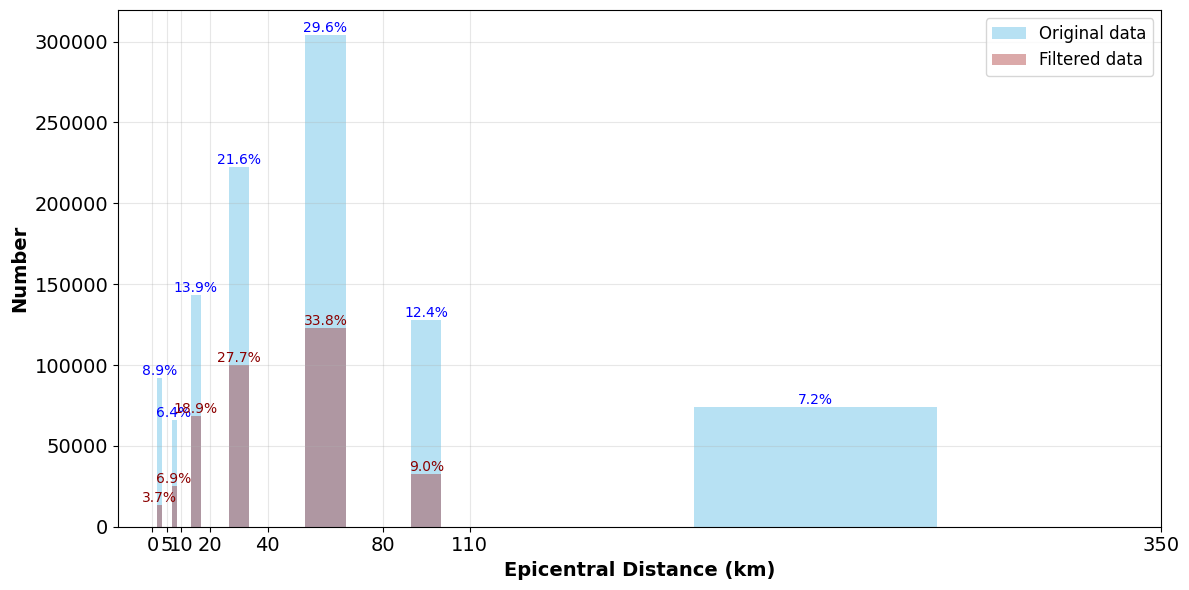

In [3]:
# -*- coding: utf-8 -*-
"""MagNet_chronological_split_EDA_v4_COPY.ipynb"""

from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision torchaudio
!pip install h5py pandas tqdm matplotlib torchinfo seaborn
# !pip install obspy

import time
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time

# import obspy
# from obspy import UTCDateTime
# from obspy.clients.fdsn import Client

# start time
start_time = time.time()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Disable cuDNN benchmarking to avoid cuDNN warnings
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = True

# Data loading and conversion functions
class EarthquakeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def load_data(file_name, file_list):
    X = []
    Y = []
    dtfl = h5py.File(file_name, 'r')
    for evi in tqdm(file_list):
        dataset = dtfl.get(f'data/{evi}')
        if dataset is None:
            print(f"Dataset not found for event ID: {evi}")
            continue
        data = np.array(dataset)
        spt = int(dataset.attrs['p_arrival_sample'])
        dshort = data[spt-100:spt+2900, :]
        X.append(dshort)
        mag = round(float(dataset.attrs['source_magnitude']), 2)
        Y.append(mag)
    dtfl.close()
    X = np.array(X)  # Convert list to numpy array
    Y = np.array(Y)  # Convert list to numpy array
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

def string_convertor(dd):
    dd2 = dd.split()
    SNR = []
    for d in dd2:
        if d not in ['[', ']']:
            dL = d.split('[')
            dR = d.split(']')
            if len(dL) == 2:
                dig = dL[1]
            elif len(dR) == 2:
                dig = dR[0]
            elif len(dR) == 1 and len(dL) == 1:
                dig = d
            try:
                dig = float(dig)
            except Exception:
                dig = None
            SNR.append(dig)
    return SNR

# Define the paths to your data files
file_name = "/content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Datasets/STEAD/merge.hdf5"
csv_file = "/content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Datasets/STEAD/merge.csv"

# Verify file existence
assert os.path.isfile(file_name), f"HDF5 file not found at {file_name}"
assert os.path.isfile(csv_file), f"CSV file not found at {csv_file}"

# Load and filter the dataset
df = pd.read_csv(csv_file, low_memory=False)
print(f"Initial number of records: {len(df)}")

# Display the value counts for the 'trace_category' column before filtering
print("Value counts before filtering:")
trace_category_counts_before = df["trace_category"].value_counts()
print(trace_category_counts_before)

# Store original dataframe before preprocessing
initial_df = df.copy()

# Ensure the 'source_origin_time' column is in datetime format
df['source_origin_time'] = pd.to_datetime(df['source_origin_time'])

# Sort by source_origin_time to ensure chronological order
df = df.sort_values(by='source_origin_time')

# Simplified filtering for debugging
df = df[df.trace_category == 'earthquake_local']
df = df[df.source_distance_km <= 110]
df = df[df.source_magnitude_type == 'ml']
df = df[df.p_arrival_sample >= 200]
df = df[df.p_arrival_sample + 2900 <= 6000]
df = df[df.p_arrival_sample <= 1500]
df = df[df.s_arrival_sample >= 200]
df = df[df.s_arrival_sample <= 2500]

# Fix coda_end_sample column parsing
df['coda_end_sample'] = df['coda_end_sample'].apply(lambda x: float(x.strip('[]')))
df = df.dropna(subset=['coda_end_sample'])
df = df[df['coda_end_sample'] <= 3000]

df = df[df.p_travel_sec.notnull()]
df = df[df.p_travel_sec > 0]
df = df[df.source_distance_km.notnull()]
df = df[df.source_distance_km > 0]
df = df[df.source_depth_km.notnull()]
df = df[df.source_magnitude.notnull()]
df = df[df.back_azimuth_deg.notnull()]
df = df[df.back_azimuth_deg > 0]
df.snr_db = df.snr_db.apply(lambda x: np.mean(string_convertor(x)))
df = df[df.snr_db >= 20]


# Define bins and labels
bins_before = [0, 5, 10, 20, 40, 80, 110, 350]
bins_after = [0, 5, 10, 20, 40, 80, 110]

# Create figure
plt.figure(figsize=(12, 6))

# Calculate percentages for both distributions
valid_distances_before = initial_df['source_distance_km'].dropna()
total_before = len(valid_distances_before)
counts_before, edges_before = np.histogram(valid_distances_before, bins=bins_before)
percentages_before = np.round((counts_before/total_before) * 100, 1)
# Adjust the largest percentage to make sum exactly 100%
percentages_before[np.argmax(percentages_before)] += 100 - np.sum(percentages_before)

valid_distances_after = df['source_distance_km'].dropna()
total_after = len(valid_distances_after)
counts_after, edges_after = np.histogram(valid_distances_after, bins=bins_after)
percentages_after = np.round((counts_after/total_after) * 100, 1)

# Adjust percentages to sum to exactly 100%
percentages_before = percentages_before * (100/percentages_before.sum())
percentages_after = percentages_after * (100/percentages_after.sum())

# Plot histograms
width = 0.35  # Width of bars

# Before preprocessing
plt.hist(valid_distances_before,
         bins=bins_before,
         color='skyblue',
         alpha=0.6,
         label='Original data',
         rwidth=width)

# Add percentage labels for before preprocessing
for i, percentage in enumerate(percentages_before):
    if percentage > 0:
        center = (edges_before[i] + edges_before[i+1])/2
        plt.text(center, counts_before[i],
                f'{percentage:.1f}%',
                ha='center', va='bottom',
                color='blue', fontsize=10)

# After preprocessing
plt.hist(valid_distances_after,
         bins=bins_after,
         color='brown',
         alpha=0.4,
         label='Filtered data',
         rwidth=width)

# Add percentage labels for after preprocessing
for i, percentage in enumerate(percentages_after):
    if percentage > 0:
        center = (edges_after[i] + edges_after[i+1])/2
        plt.text(center, counts_after[i],
                f'{percentage:.1f}%',
                ha='center', va='bottom',
                color='darkred', fontsize=10)

# Customize plot
plt.xlabel('Epicentral Distance (km)', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Set equal width bins visualization
plt.xticks(bins_before)

plt.tight_layout()
plt.show()

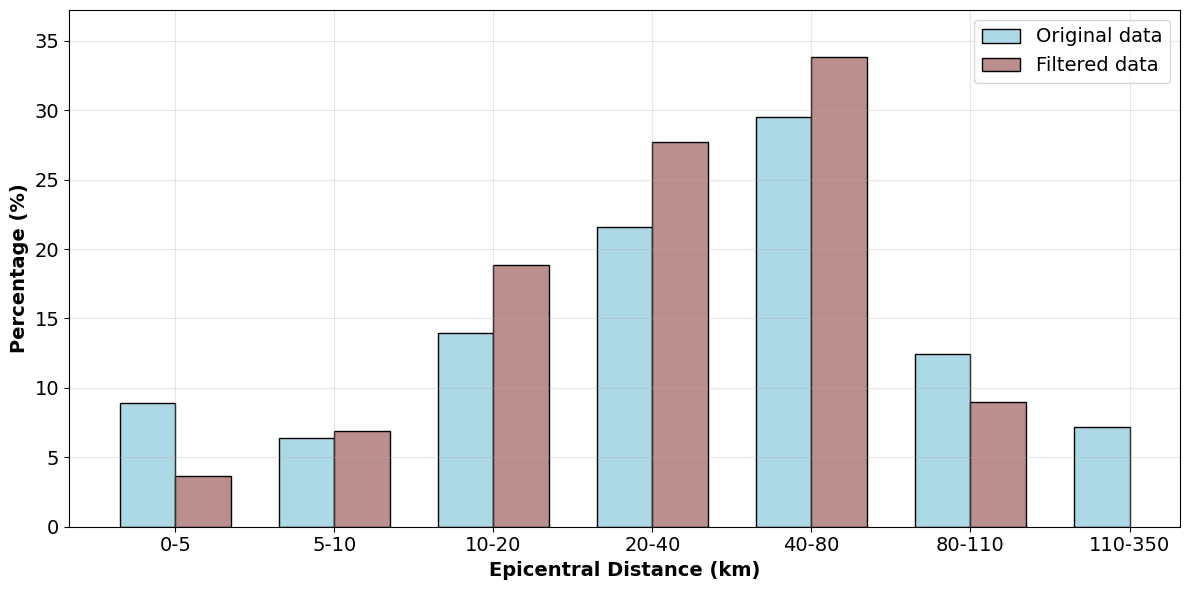

In [5]:
# # Create figure - y-axix is the Absolute Nubmber
# plt.figure(figsize=(12, 6))

# # Set up bar positions
# x = np.arange(len(bins_before)-1)  # -1 because we have one less bar than bin edges
# width = 0.35  # width of bars

# # Plot bars side by side
# plt.bar(x - width/2, counts_before, width, label='Original data', color='skyblue')
# plt.bar(x[:len(counts_after)] + width/2, counts_after, width, label='Filtered data', color='brown')

# # Add percentage labels
# for i, percentage in enumerate(percentages_before):
#     plt.text(i - width/2, counts_before[i], f'{percentage:.1f}%',
#              ha='center', va='bottom', color='blue', fontsize=12)

# for i, percentage in enumerate(percentages_after):
#     plt.text(i + width/2, counts_after[i], f'{percentage:.1f}%',
#              ha='center', va='bottom', color='darkred', fontsize=12)

# # Customize plot
# plt.xlabel('Epicentral Distance (km)', fontweight='bold', fontsize=14)
# plt.ylabel('Number', fontweight='bold', fontsize=14)
# plt.xticks(x, ['0-5', '5-10', '10-20', '20-40', '40-80', '80-110', '110-350'])
# plt.tick_params(axis='both', which='major', labelsize=14)
# plt.legend(fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()





# Create figure - y-axis is the relative percentage
plt.figure(figsize=(12, 6))

# Set up bar positions
x = np.arange(len(bins_before)-1)  # -1 because we have one less bar than bin edges
width = 0.35  # width of bars

# Calculate percentages for plotting on y-axis
percentages_before = (counts_before/total_before) * 100
percentages_after = (counts_after/total_after) * 100

# Plot bars side by side using percentages instead of counts
plt.bar(x - width/2, percentages_before, width, label='Original data', color='lightblue', edgecolor='black')
plt.bar(x[:len(counts_after)] + width/2, percentages_after, width, label='Filtered data', color='rosybrown', edgecolor='black') # color='#D4A6A6'

# Set y-axis limit with 10% padding for headroom
plt.ylim(0, max(np.max(percentages_before), np.max(percentages_after)) * 1.1)

# Customize plot
plt.xlabel('Epicentral Distance (km)', fontweight='bold', fontsize=14)
plt.ylabel('Percentage (%)', fontweight='bold', fontsize=14)  # Changed y-axis label
plt.xticks(x, ['0-5', '5-10', '10-20', '20-40', '40-80', '80-110', '110-350'])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

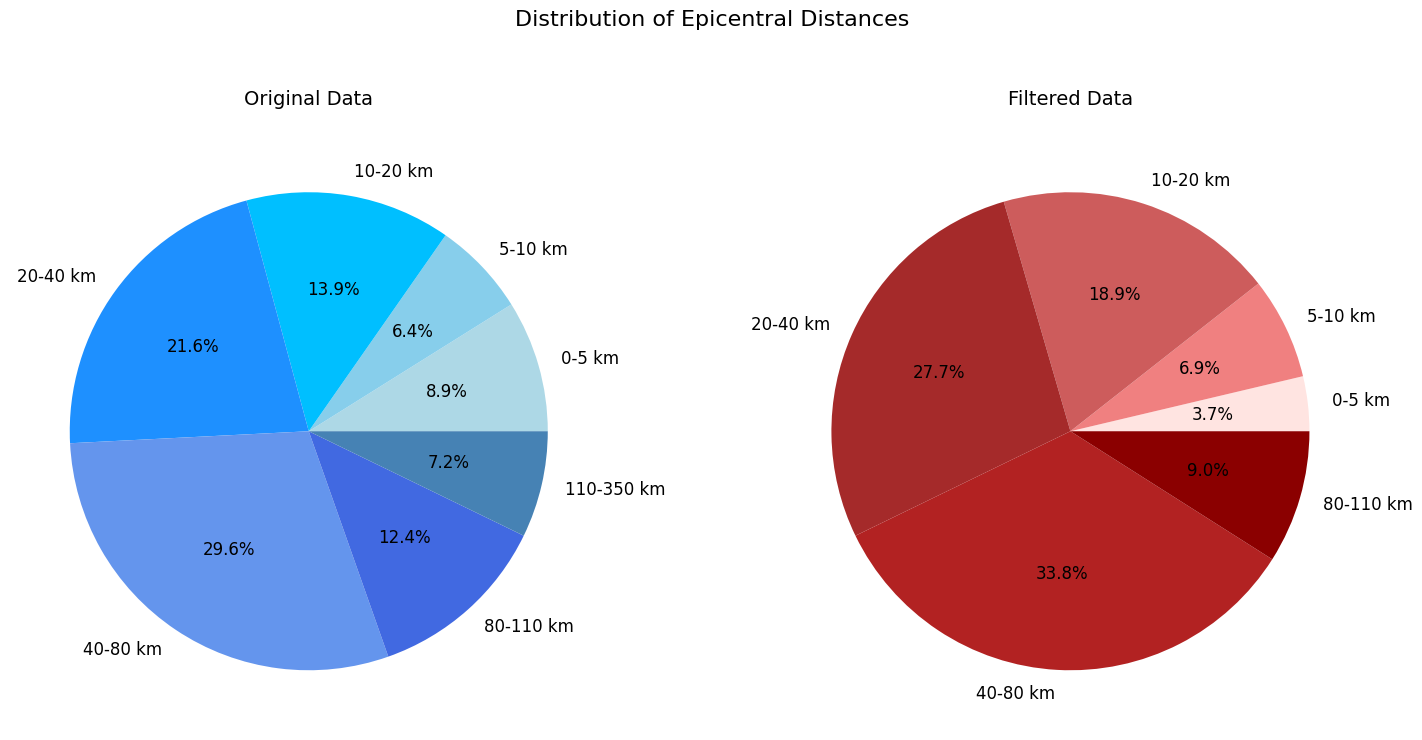

In [6]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Data preparation
labels = ['0-5 km', '5-10 km', '10-20 km', '20-40 km', '40-80 km', '80-110 km', '110-350 km']

# Calculate percentages (ensuring they sum to 100%)
percentages_before = np.around((counts_before/total_before) * 100, 1)
percentages_before[np.argmax(percentages_before)] += 100 - np.sum(percentages_before)

percentages_after = np.around((counts_after/total_after) * 100, 1)
percentages_after[np.argmax(percentages_after)] += 100 - np.sum(percentages_after)

# First pie chart (Original data)
patches1, texts1, autotexts1 = ax1.pie(percentages_before,
                                      labels=labels,
                                      autopct='%1.1f%%',
                                      colors=['lightblue', 'skyblue', 'deepskyblue', 'dodgerblue',
                                             'cornflowerblue', 'royalblue', 'steelblue'])
ax1.set_title('Original Data', fontsize=14, pad=20)

# Second pie chart (Preprocessed data)
patches2, texts2, autotexts2 = ax2.pie(percentages_after[:6],
                                      labels=labels[:6],
                                      autopct='%1.1f%%',
                                      colors=['mistyrose', 'lightcoral', 'indianred', 'brown',
                                            'firebrick', 'darkred'])
ax2.set_title('Filtered Data', fontsize=14, pad=20)

# Adjust text properties
plt.setp(autotexts1 + autotexts2, size=12)
plt.setp(texts1 + texts2, size=12)

# Add a common legend
fig.suptitle('Distribution of Epicentral Distances', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()